# Implementing a Simple Classification Neural Network using PyTorch

In this notebook, we will explore the implementation of a simple classification neural network using the [PyTorch](https://pytorch.org/) library. Our focus will be on understanding the key concepts and steps involved in building a classification neural network using PyTorch.

We will work with a synthetic dataset with two-dimensional features, allowing us to easily observe and visualize the data. The notebook will follow a step-by-step approach, covering data creation, dataset preparation, setting up a neural network architecture, training the model and visualizing the results. Additionally, we will carefully explore the required data dimensions and analyze how calculation of loss is performed.

Throughout the notebook, we hope to provide clear code examples and highlight the key concepts and techniques involved. By the end, you will have developed a practical understanding of classification using neural networks and how to implement classification models using PyTorch.

As with our [previous experiment](https://mmakipaa.github.io/svg/svg_with_pytorch.html) with Stochastic Gradient Descent, we have explored the use of [ChatGPT](https://openai.com/blog/chatgpt) to aid generation of text descriptions based on  manually crafted code.



## Library imports

First, we import the necessary libraries for our implementation. We will use [Pytorch](https://pytorch.org/) to define and train our neural network model. We will also use [NumPy](https://numpy.org/) and [Pandas](https://pandas.pydata.org/) for data handling, and [Matplotlib](https://matplotlib.org/) and [Seaborn](https://seaborn.pydata.org/) for visualization.

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, rgb2hex
import seaborn as sns

from copy import deepcopy

We confirm the version of Pytorch used as [version 2.0](https://pytorch.org/blog/pytorch-2.0-release/):

In [2]:
print(torch.__version__)

2.0.0


In [3]:
torch.set_printoptions(precision=4, sci_mode=False)

## Check for GPU support

We check for the availability of a [CUDA](https://en.wikipedia.org/wiki/CUDA)-enabled GPU and set the device to use it for our Pytorch implementation. Even if the current GPU is a modest one, using a GPU can significantly speed up the training in a more realistic setting.

We will use the Pytorch [torch.cuda](https://pytorch.org/docs/stable/cuda.html) library to check for the availability of a GPU and set the device to use it.

In [4]:
torch.cuda.is_available()

True

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
torch.cuda.get_device_name(0) if torch.cuda.is_available() else "NA"

'NVIDIA GeForce GTX 960'

## Define colors and styles for visualizations

We use the ColorBrewer [RdYlBu](https://colorbrewer2.org/#type=diverging&scheme=RdYlBu&n=7) colormap for our visualizations of learning progress. Later in the code, we refer to these colors as `colors['red']`, `colors['orange']`, and so on, instead of default color names. 

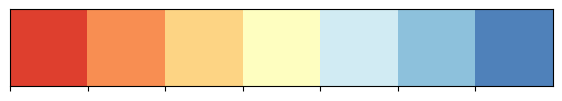

In [7]:
RdYlBu = sns.color_palette("RdYlBu", 7)
sns.palplot(RdYlBu)

colors = dict(zip(['red', 'orange', 'lightorange', 'yellow',
              'lightblue', 'steelblue', 'blue'],
                  RdYlBu))

We select colors from the categorical ColorBrewer palette [Set2](https://colorbrewer2.org/?type=qualitative&scheme=Set2&n=3) to indicate our classes.

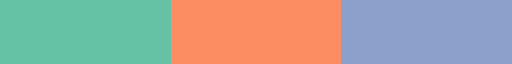

In [8]:
class_colors = ListedColormap(sns.color_palette("Set2", 3))
class_colors

Finally, we use a cubehelix palette for visualizations of evolution of the class boundaries during the learning process. We set `dark` and `light` values to limit the intensity range.

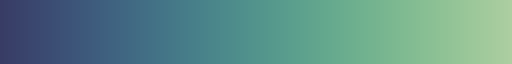

In [9]:
palette = sns.cubehelix_palette(
    start=.5, rot=-.75, dark=0.25, light=0.75,
    reverse=True, as_cmap=True)

palette

We define default axis styles and image size for our plots, aiming at 16:9 aspect ratio for our images.

In [10]:
def set_ax(ax):
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)

    plt.setp(ax.spines.values(), linewidth=1.5)


def set_axlim(ax):
    ax.set_xlim(X1_MIN, X1_MAX)
    ax.set_ylim(X2_MIN, X2_MAX)

    ax.set_xticks([X1_MIN, X1_MAX])
    ax.set_yticks([X2_MIN, X2_MAX])

In [11]:
FIG_W = 16
FIG_H = 9

## Classification problem definition

To set up our classification problem, we create an artificial two-dimensional dataset. The two-dimensional nature of the dataset make it easily explorable and visualizable later, for example to analyze classification probabilities and visualize the evolution of class boundaries during training.

The dataset consists of data points represented by coordinates $x=(x1,x2)$ assigned to one of three classes, labeled 0, 1, and 2. We represent the data points in the two-dimensional space using a tensor `x`, with `x1` and `x2` as the respective x and y coordinates, constrained within following limits.

In [12]:
X1_MIN = 0
X1_MAX = 16
X2_MIN = 0
X2_MAX = 9

We define two functions, `func1` and `func2`, to establish the class boundaries for our classification problem. Given the x-coordinate `x1`, the function gives the `x2` coordinate of the boundary.

In [13]:
def func1(x):
    return - 0.4 * torch.cos(0.55 * x) * x + 0.25 * x + 4.5


def func2(x):
    return 2 * x - 12

We visualize these functions in the following. The orange, alternating non-linear boundary is defined by `func1` and the blue linear boundary is defined by `func2`. 

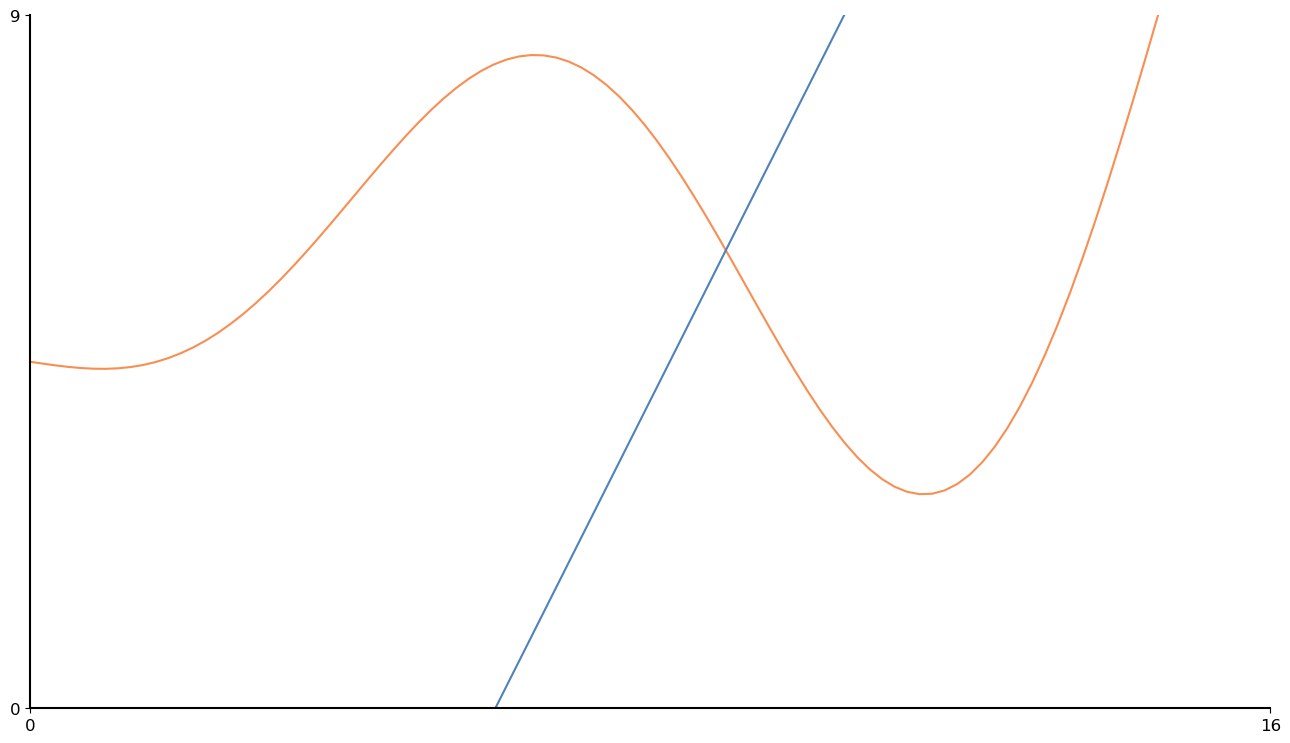

In [14]:
num_points = 100
points = torch.linspace(X1_MIN, X1_MAX, num_points)

fig = plt.figure(figsize=(FIG_W, FIG_H))

plt.plot(points, func1(points), color=colors['orange'])
plt.plot(points, func2(points), color=colors['blue'])

ax = fig.gca()

sns.despine()
set_ax(ax)
set_axlim(ax)

### Probabilistic Class Label Assignment

We want to create a classification problem setting that is probabilistic in nature with overlap between classes. Rather than using rigid class boundaries, we set the boundaries to define probablity distributions so that the transition from one class to another becomes gradual.

We utilize the boundary functions `func1` and `func2` to represent the midpoint of a cumulative probability distribution. At the boundary, where the cumulative probability is 0.5, observations are equally likely to belong to either class, while on both sides of the boundary, the probabilities of belonging to one class decrease and the probabilities of belonging to the other class increase.

Points above the orange boundary in the above figure are more likely to belong to class 2, while points below the orange boundary are more likely to belong to class 1 when they are above the blue boundary and to class 0 when below the blue boundary.



The `get_class_label` function assigns class labels to two-dimesional data points based on their positions relative to the boundaries, implementing the logic discussed above to achieve gradual transition between classes around the boundary.

First, the function calculates the distances between the data points and the centerlines, determined by the functions `func1` and `func2`. Then, it uses the cumulative distribution function (cdf) of a normal distribution with mean 0 and standard deviation 1 to determine the probabilities that a data point at a certain distance from the boundary belongs to a particular class.

To assign a class label, the function generates a random value and compares it against the calculated cumulative probabilities. If the random value is less than the probability for class 2 (`p_from_c2`), the data point is assigned class label 2.

For data points that are not assigned to class 2, further evaluation is performed to determine if they belong to class 0 or class 1 following a similar logic.

In [15]:
BOUNDARY_MEAN = 0
BOUNDARY_STD = 1

norm_cdf = torch.distributions.normal.Normal(torch.tensor(BOUNDARY_MEAN).to(device),
                                             torch.tensor(BOUNDARY_STD).to(device)).cdf

In [16]:
def get_class_label(x):
    x1 = x[:, 0]
    x2 = x[:, 1]

    # Calculate distances to class border centerlines, given by func1 and func2
    dist_to_b1 = x2 - func1(x1)
    dist_to_b2 = x2 - func2(x1)

    # Calculate probabilities that data points come from class above the threshold
    p_from_c2 = norm_cdf(dist_to_b1)
    p_from_c1 = norm_cdf(dist_to_b2)

    # Classify data points
    class2 = torch.where(torch.rand(
        x2.size(0)).to(device) < p_from_c2, 2, 0)
    class01 = torch.where(torch.rand(
        x2.size(0)).to(device) < p_from_c1, 1, 0)
    class2[class2 == 0] = class01[class2 == 0]

    return class2.to(device)

We define the function `find_roots` first, to locate the zero crossing of class boundary defined by `func2`, and second, to find the intersection point of the class boundary centerlines. We calculate the `x1`-coordinates of these crossings and store them for later use in visualizations.

In [17]:
# for inspiration, see https://stackoverflow.com/questions/46909373/how-to-find-the-exact-intersection-of-a-curve-as-np-array-with-y

def find_roots(x, y):
    s = torch.sign(y)
    cp = torch.nonzero(s[:-1]-s[1:], as_tuple=True)
    return (x[:-1][cp] + (x[1:][cp] - x[:-1][cp])
            * torch.abs(y[:-1][cp])
            / (torch.abs(y[:-1][cp]) + torch.abs(y[1:][cp])))

In [18]:
x_points = torch.linspace(X1_MIN, X1_MAX, 200)

class_boundary1 = func1(x_points)
class_boundary2 = func2(x_points)

cross1 = find_roots(x_points, class_boundary2)[0]
cross2 = find_roots(x_points, class_boundary2 - class_boundary1)[0]

boundary_crossings = (cross1, cross2)

print(f"{cross1:.2f}, {cross2.item():.2f}")

6.00, 8.97


## Random seed initialization

We set the random seed to ensure that the random initialization is consistent across repeated runs. 

In [19]:
RANDOM_SEED = 2100
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

We use `torch.Generator` ([link](https://pytorch.org/docs/stable/generated/torch.Generator.html#torch.Generator)) to seed the generation of samples from our datasets. We create a random number generator object `gen` and set the seed of the generator to ensure reproducibility of random number generation throughout the code.

In [20]:
gen = torch.Generator()
gen.manual_seed(RANDOM_SEED)

## Create the data sets

In the following section, we create the datasets used in our training. First, we define the desired dataset sizes as constants.

In [21]:
TRAINING_SAMPLES = 2000
EVALUATION_SAMPLES = 1000

MINIBATCH_SIZE = 50
EVALUATION_BATCH_SIZE = EVALUATION_SAMPLES

### Custom Dataset class

The `ClassificationDataset` class represents a PyTorch [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) subclass  for our simple classification problem. It takes the minimum and maximum values for the `x1` and `x2` dimensions, the desired number of samples, and creates a dataset with corresponding class labels.

The `create_data` method generates random data points within the given ranges and assigns class labels to them using the previously defined `get_class_label` function. The `__getitem__` method returns an individual data point and its class label at the specified index.

For plotting convenience, the `as_numpy` method returns the dataset as numpy arrays, converting the tensors to the CPU and detaching them from the computational graph.

In [22]:
class ClassificationDataset(Dataset):
    def __init__(self, x1_min, x1_max, x2_min, x2_max, samples):
        self._x, self._c = self.create_data(x1_min, x1_max,
                                            x2_min, x2_max,
                                            samples)

    def __len__(self):
        return len(self._x)

    def __getitem__(self, index):
        return self._x[index], self._c[index]

    def create_data(self, x1_min, x1_max, x2_min, x2_max, samples):
        x = (torch.rand(size=(samples, 2))
             * torch.tensor([x1_max-x1_min, x2_max-x2_min])
             + torch.tensor([x1_min, x2_min])).to(device)
        c = get_class_label(x)
        return x, c

    def as_numpy(self):
        return (self._x
                .to('cpu').detach().numpy(),
                self._c
                .to('cpu').detach().numpy())

### Data Preparation and Dataloader Initialization

A Pytorch `DataLoader` ([link](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)) is used to handle the datasets. It takes the dataset as input, along with parameters `batch size`, `shuffle` flag (set to `True` for randomizing the order of data samples during training), and our random number generator, `gen`, used to ensure that the the data is recreated in the same data sampling order during different experiements.

To evaluate the performance of our model on unseen data that was not used during the model training process, we crete an evaluation dataset, `evaluation_dataset`, following a similar approach. 

We utilize the `ClassificationDataset` class to create both the training and evaluation loaders for our classification problem.

In [23]:
training_dataset = ClassificationDataset(
    X1_MIN, X1_MAX,
    X2_MIN, X2_MAX,
    TRAINING_SAMPLES)

training_loader = DataLoader(training_dataset,
                             batch_size=MINIBATCH_SIZE,
                             shuffle=True,
                             generator=gen)

In [24]:
evaluation_dataset = ClassificationDataset(
    X1_MIN, X1_MAX,
    X2_MIN, X2_MAX,
    EVALUATION_SAMPLES)

evaluation_loader = DataLoader(
    evaluation_dataset, batch_size=EVALUATION_BATCH_SIZE, shuffle=False)

We store the training dataset input features and corresponding class labels as numpy arrays, to be used for visualizations later in the notebook.

In [25]:
x_array, c_array = training_dataset.as_numpy()

We perform a quick check on the number of data points in each class, noting that the distribution of samples across classes is relatively balanced.

In [26]:
np.array(np.unique(c_array, return_counts=True)).T

array([[  0, 690],
       [  1, 639],
       [  2, 671]])

<a id="datasetvisualization"></a>
### Dataset visualization

We are now ready to visualize the training dataset we just created. 

We define a utility function that enables the plotting of class decision boundary centerlines in our visualizations. We employ the `boundary_crossings` calculated earlier to determine the range of x-values for the linear boundary.

In [27]:
def plot_class_boundaries(*, color='darkgray', linewidth=2):

    num_points = 100

    x1 = torch.linspace(X1_MIN, X1_MAX, num_points)
    y1 = func1(x1)

    sns.lineplot(x=x1,
                 y=y1,
                 color=color, linewidth=linewidth)

    x2 = torch.linspace(boundary_crossings[0].item(),
                        boundary_crossings[1].item(),
                        num_points)
    y2 = func2(x2)

    sns.lineplot(x=x2,
                 y=y2,
                 color=color, linewidth=linewidth)

We assign a specific color and marker style to each data point based on its class label:

- Below the curved boundary and to the right of the linear boundary, *class 0* is represented by green circles.
- Below the curved boundary and to the left of the linear boundary, *class 1* is represented by orange crosses.
- And finally, above the curved boundary, *class 2* is represented by blue squares.

The `plot_class_boundaries` function is used to add centerlines of the class boundaries to the image.

Due to the classification problem setting, there is overlap in the observations of different classes. This can be seen as points appearing on the 'wrong side' of the class boundary centerline.

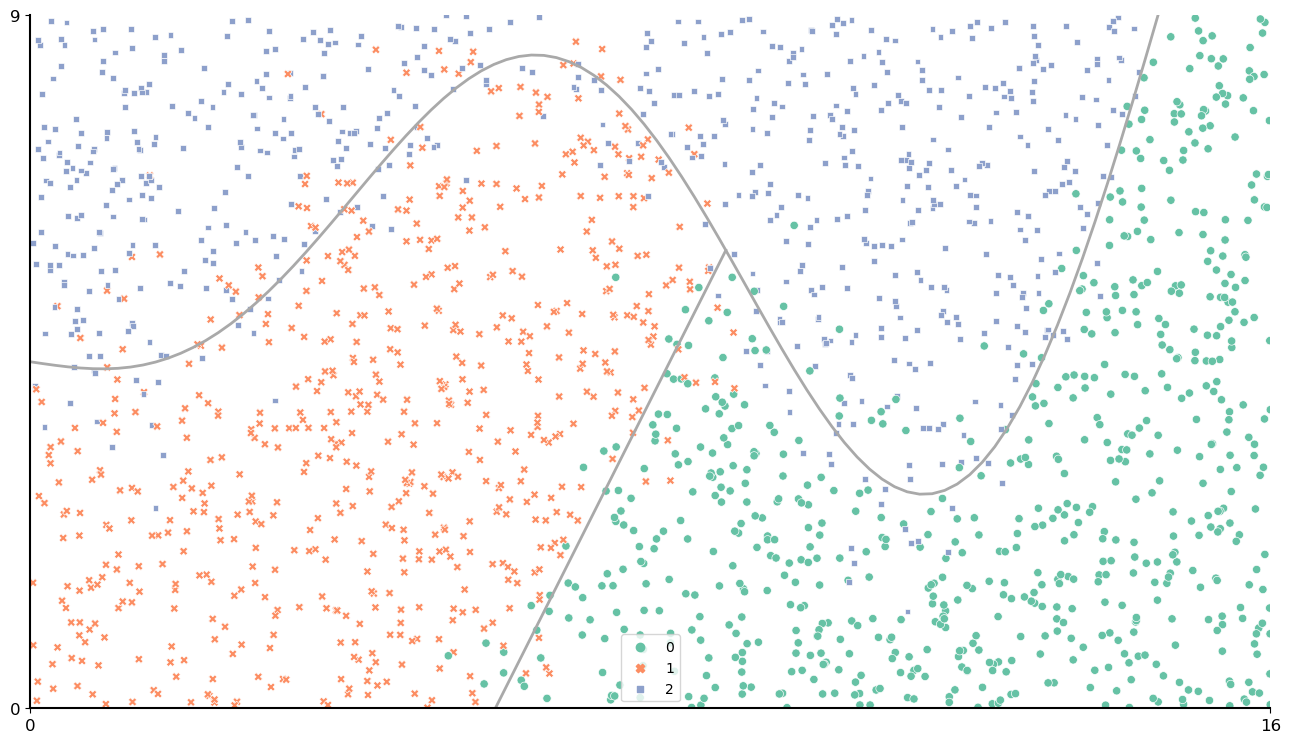

In [28]:
fig = plt.figure(figsize=(FIG_W, FIG_H))

sns.scatterplot(x=x_array[:, 0],
                y=x_array[:, 1],
                hue=c_array,
                style=c_array,
                palette=class_colors,
                legend=True)

plot_class_boundaries()

ax = fig.gca()

sns.despine()
set_ax(ax)
set_axlim(ax)

### Points on the Wrong Side of the Class Boundaries

We refine our visualization further by repeating the above plot, but this time plotting the points from the training dataset on 'the wrong side' of the class boundary centerlines. 

To extract these values, we create a boolean mask `is_wrong_side` to indicate whether each point is on the other side of its corresponding boundary.

Out of the training samples, we observe that there are 185 such values, which accounts for approximately 9.25% of the dataset. Assuming that our classifier aims to approximate the centerlines, this sets the maximum achievable training accuracy for our model at around 90.75%.

In [29]:
is_wrong_side = (training_dataset._x[:,1] > func1(training_dataset._x[:,0])) & ( training_dataset._c != 2)
is_wrong_side = is_wrong_side | (training_dataset._x[:,1] < func1(training_dataset._x[:,0])) & ( training_dataset._c == 2)
is_wrong_side = is_wrong_side | (training_dataset._x[:,1] < func2(training_dataset._x[:,0])) & ( training_dataset._c == 1)
is_wrong_side = is_wrong_side | (training_dataset._x[:,1] > func2(training_dataset._x[:,0])) & ( training_dataset._c == 0)
is_wrong_side = is_wrong_side.to('cpu').detach().numpy()

print(f"Count: {sum(is_wrong_side)}, Percentage: {(sum(is_wrong_side)) / TRAINING_SAMPLES}")

Count: 185, Percentage: 0.0925


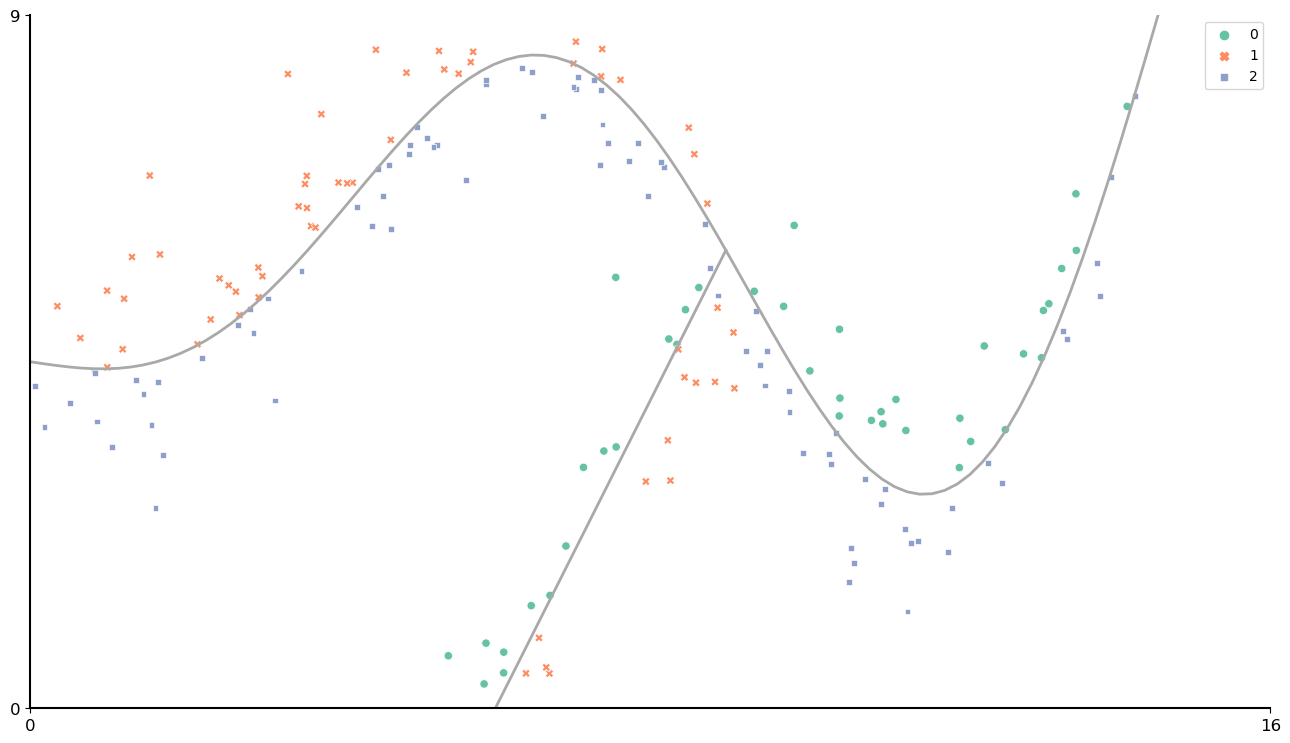

In [30]:
fig = plt.figure(figsize=(FIG_W, FIG_H))

sns.scatterplot(x=x_array[is_wrong_side, 0],
                y=x_array[is_wrong_side, 1],
                hue=c_array[is_wrong_side],
                style=c_array[is_wrong_side],
                palette=class_colors,
                legend=True)

plot_class_boundaries()

ax = fig.gca()

sns.despine()
set_ax(ax)
set_axlim(ax)

## Defining a Neural Network Model

In the following, we define our neural network classifier using PyTorch's `nn.Module` class ([link](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module)). The use of `torch.nn.Sequential` ([link](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential)) allows us to easily compose the layers in a sequential manner without explicitly specifying the connections.

### Neural Network Architecture

The neural network architecture consists of an input layer, a hidden layer with hyperbolic tangent activation, and a linear output layer. Each layer is fully connected.  

The `forward` method defines how the two-dimensional input features $x=(x_1,x_2)$ are passed through the layers, generating three outputs, one for each class.

These outputs of the final layer of the network are the *logits*, which represent the unnormalized predictions or scores assigned to each class by the model. We will discuss this [a bit later](#neuralnetworkforwardpass) in more detail. 

### Hidden Layer Size

We have chosen 8 neurons as the size of our hidden layer in our current example without extensively exploring other options.

Determining the optimal size for the hidden layer is a complex task, as it depends on the specific classification problem. Sufficient number of hidden neurons is necessary for the model to capture non-linear relationships in the data. However, using too many hidden neurons can lead to overfitting, where the model may struggle to generalize well to unseen data. In simpler problems like ours, a smaller number of hidden neurons may be adequate.

In subsequent sections, we will find out whether the chosen model is capable of representing the non-linear classification boundaries and how well the model addresses the overlapping classes in the observed data.

In [31]:
num_features = 2
num_hidden = 8
num_classes = 3

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(num_features, num_hidden,
                            dtype=torch.float32),
            torch.nn.Tanh(),
            torch.nn.Linear(num_hidden, num_classes,
                            dtype=torch.float32),
        )

    def forward(self, x):
        return self.model(x)

We instantiate our neural network classifier model by creating an instance of the `Classifier` class and moving it to the specified device (e.g., CPU or GPU) using the `.to()` method.

We print the model to verify its structure and to ensure that it matches our intended design.

In [32]:
model = Classifier().to(device)
print(model)

Classifier(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=3, bias=True)
  )
)


## Setting up the loss function, optimizer, and scheduler

Next we define the loss function, optimizer, and scheduler with the appropriate learning parameters.

In [33]:
TRAINING_EPOCHS = 1000
REPORTING_INTERVAL = 20

### Defining the loss function for classification

The [Cross Entropy Loss](https://en.wikipedia.org/wiki/Cross_entropy) is a commonly used loss function for classification tasks in neural networks. In our case, we are using the Pytorch implementation [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) function to train our classification neural network.


In [34]:
loss_fn = nn.CrossEntropyLoss(reduction='sum')


The `reduction='sum'` argument specifies that the loss will be computed as the sum of individual losses for each sample in the batch, which is suitable for our training scenario.


### Defining optimizer and scheduler

The [Stochastic Gradient Descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) optimizer [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) is used to update the parameters of our neural network model during the training process.

The `model.parameters()` function provides the parameters of the model to be optimized as the optimizer iteratively adjusts the model's parameters to minimize the loss function during training.

The learning rate determines the step size taken during parameter updates. 

The learning rate `scheduler` is used to gradually reduce the step size of the optimizer during training.

In this case, the scheduler is configured with a linear decay schedule, instantiated as `torch.optim.lr_scheduler.LinearLR` ([link](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html#torch.optim.lr_scheduler.LinearLR)), where the learning rate gradually decreases over the training iterations from `INITIAL_LEARNING_RATE` to a fraction, defined by `end_factor=0.01`.




In [35]:
INITIAL_LEARNING_RATE = 0.005

optimizer = torch.optim.SGD(model.parameters(),
                            lr=INITIAL_LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,
                                              start_factor=1.0,
                                              end_factor=0.01,
                                              total_iters=TRAINING_EPOCHS)

## Training Process Definition

Now, after setting up the neural network model architecture and the necessary training parameteres, the next step is to define the training process. 

The `train` function defined below is responsible for training the neural network classifier model over a specified number of epochs. The function takes the model to be trained as input along with the number of training epochs to perform, as well as the used loss function, optimizer, scheduler and generator.

The function iterates over batches of data from the training_loader and for each batch, calculates the model predictions (`c_logits`) on the input data (`x_batch`). It then computes the loss between the logits and the target class labels (`c_batch`).

The function then performs backpropagation to update the model's parameters using the optimizer.

After each epoch, the learning rate is adjusted using a scheduler. 

At this point, model performance on the training and evaluation datasets, including loss and classification accuracy is also calculated and recorded. The predicted class labels are obtained by taking the `argmax` of the predicted logits.

Note how the function also stores a copy of the model parameters at this intermediate training state to the report for later analysis.

In [36]:
def train(model, epochs, loss_fn, optimizer, scheduler, gen):

    report = []
    gen.manual_seed(RANDOM_SEED)

    for epoch in range(epochs):

        model.train()

        for x_batch, c_batch in training_loader:

            c_logits = model(x_batch)

            optimizer.zero_grad()
            loss = loss_fn(c_logits, c_batch)

            loss.backward()
            optimizer.step()

        scheduler.step()

        if (epoch % REPORTING_INTERVAL == 0) | (epoch == epochs - 1):

            with torch.no_grad():
                model.eval()

                train_loss = 0
                train_accuracy = 0

                for x_batch, c_batch in training_loader:

                    train_logits = model(x_batch)
                    train_loss += loss_fn(train_logits,
                                          c_batch)

                    train_preds = torch.argmax(train_logits, dim=1)
                    train_accuracy += (train_preds == c_batch).sum()

                eval_loss = 0
                eval_accuracy = 0

                for x_eval_batch, c_eval_batch in evaluation_loader:

                    eval_logits = model(x_eval_batch)
                    eval_loss += loss_fn(eval_logits, c_eval_batch)

                    eval_preds = torch.argmax(eval_logits, dim=1)
                    eval_accuracy += (eval_preds == c_eval_batch).sum()

                print(f"Epoch {epoch}, training loss: {train_loss / TRAINING_SAMPLES:.4f}"
                      f", evaluation loss: {eval_loss / EVALUATION_SAMPLES:.4f}"
                      f", training_accuracy: {train_accuracy.item() / TRAINING_SAMPLES}",
                      f", evaluation accuracy: {eval_accuracy / EVALUATION_SAMPLES:.4f}")

                report.append({
                    "epoch": epoch,
                    "training_loss": train_loss.item() / TRAINING_SAMPLES,
                    "eval_loss": eval_loss.item() / EVALUATION_SAMPLES,
                    "training_accuracy": train_accuracy.item() / TRAINING_SAMPLES,
                    "eval_accuracy": eval_accuracy.item() / EVALUATION_SAMPLES,
                    "state_dict": deepcopy(model.state_dict()),
                    "learning_rate": scheduler.get_last_lr()
                })

    return report

## Understanding Data Dimensions and Loss Functions

Before diving into the training process and visualizing the results, we feel it makes sense to take a moment to ensure that we have a good understanding of the shape and structure of our data, as well as their required formats at model forward propagation, class prediction and loss calculations.

### Training Data and Input Features

First we recall how our training data was set up. Below, we show the shape of the input features stored in the `ClassificationDataset` instance `training_dataset`, which consists of `TRAINING_SAMPLES` rows (2000) and two columns (`x1` and `x2`) since our input data is two-dimensional. We print the first rows of the feature matrix to provide a glimpse of the actual data.

In [37]:
print(training_dataset._x.shape)
print(training_dataset._x[0:5, :])

torch.Size([2000, 2])
tensor([[14.2655,  2.7153],
        [14.8215,  6.1776],
        [ 3.6693,  7.8116],
        [15.7693,  0.2132],
        [ 2.4541,  2.1826]], device='cuda:0')


Then, we recall that the true classification labels are stored stored in the `training_dataset` in a one-dimensional tensor, or a _vector_, which consists of `TRAINING_SAMPLES` labels assigned to each sample (0, 1, or 2). Again, we provide a glimpse of the labels.

In [38]:
print(training_dataset._c.shape)
print(training_dataset._c[0:5])

torch.Size([2000])
tensor([0, 0, 2, 0, 1], device='cuda:0')


### Data Loader and Minibatch Extraction

We illustrate the functionality of our `DataLoader` by creating a test loader from `training_dataset` and extracting a minibatch of samples. To keep the output concise, we set the batch size to a small number.

Here, we utilize the `iter()` function to create an iterator object to iterate over `DataLoader`, an iterable object. This iterator allows us to traverse through the `test_loader` and retrieve elements one by one using the `next()` function.

By calling `next(iter(test_loader))`, we obtain a single minibatch sample. We then extract the input features `data_x` and the classification labels `data_c` from the minibatch. 

As expected, the data remains the same as before.

In [39]:
gen.manual_seed(RANDOM_SEED)
test_loader = DataLoader(training_dataset,
                         batch_size=5,
                         shuffle=False,
                         generator=gen)

data_x, data_c = next(iter(test_loader))

In [40]:
print(data_x)
print(data_x.shape)

tensor([[14.2655,  2.7153],
        [14.8215,  6.1776],
        [ 3.6693,  7.8116],
        [15.7693,  0.2132],
        [ 2.4541,  2.1826]], device='cuda:0')
torch.Size([5, 2])


In [41]:
print(data_c)
print(data_c.shape)

tensor([0, 0, 2, 0, 1], device='cuda:0')
torch.Size([5])


### One-Hot Encoding of Classification Labels

We demonstrate [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) of the classification labels `data_c`. When the class labels are represented as one-hot encoded vectors, the element corresponding to the true class is set to 1 and all other elements are set to 0.

In this particular case, one-hot encoding is not needed as Pytorch implementation of our chosen loss function `CrossEntropyLoss` expects to receive class labels instead. Nevertheless, we demonstrate how to perform one-hot encoding using `torch.nn.functional.one_hot` ([link](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html#torch.nn.functional.one_hot)). We will use the values to filter network outputs later in this section.

In [42]:
data_c_onehot = torch.nn.functional.one_hot(
    data_c).to(torch.int)

print(data_c_onehot)

tensor([[1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0]], device='cuda:0', dtype=torch.int32)


<a id="neuralnetworkforwardpass"></a>

### Neural Network Forward Pass

Next, we appy our  neural network model to process the input minibatch `data_x`, producing in the output `model_out`. Remember, that the the output layer of our model is a linear layer with three elements. Thus, the dimensions of model output here are `(N,C)`, where `N` corresponds to the minibatch size and `C` represents the number of classes in the classification problem.

These output values are unnormalized logits, one for each class, which are the raw predictions for the corresponding input sample made by the model before any activation function or normalization is applied.

It is good to note that at this point the model has not undergone training, but produces the outputs and classification predictions based on its initial weight values.

In [43]:
with torch.no_grad():

    model_out = model(data_x)
    print(model_out)
    print(model_out.shape)

tensor([[ 0.0629,  0.2914, -0.7760],
        [ 0.2565,  0.3044, -0.7050],
        [ 0.4966,  0.0161, -0.3293],
        [ 0.0391,  0.2852, -0.7763],
        [ 0.2418,  0.0831, -0.2833]], device='cuda:0')
torch.Size([5, 3])


### Interpreting Logits as Probabilities

We apply a `torch.nn.Softmax` layer ([link](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)) to the unnormalized logits obtained from the linear layer in our model. The [softmax](https://en.wikipedia.org/wiki/Softmax_function) function transforms the logits into probabilities, providing an estimate of the likelihood that a given sample belongs to a particular class.

We verify the validity of these outputs as probabilities by ensuring that their sum equals one for each presented data sample.

In [44]:
model_softmax = nn.Softmax(dim=1)
softmax_probs = model_softmax(model_out)

print(softmax_probs)
print(torch.sum(softmax_probs, dim=1))

tensor([[0.3719, 0.4674, 0.1607],
        [0.4113, 0.4315, 0.1572],
        [0.4863, 0.3008, 0.2129],
        [0.3674, 0.4700, 0.1626],
        [0.4090, 0.3490, 0.2419]], device='cuda:0')
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0')


### Predicting Class Labels

The predicted class label corresponds to the index of the highest probability value in the `Softmax` output. By selecting the index with the highest probability, we effectively determine the predicted class for each input sample as shown by returned indices below.

In [45]:
torch.max(softmax_probs, dim=1)

torch.return_types.max(
values=tensor([0.4674, 0.4315, 0.4863, 0.4700, 0.4090], device='cuda:0'),
indices=tensor([1, 1, 0, 1, 0], device='cuda:0'))

Furthermore, it is worth noting that logits and probabilities have the same magnitude order for each class. This implies that instead of applying the softmax function and then selecting the maximum probability, we can directly take the maximum value from the model's output logits.

In [46]:
torch.max(model_out, dim=1)

torch.return_types.max(
values=tensor([0.2914, 0.3044, 0.4966, 0.2852, 0.2418], device='cuda:0'),
indices=tensor([1, 1, 0, 1, 0], device='cuda:0'))

### Using Cross Entropy Loss

As said, we have selected to use the Pytorch implementation provided by `torch.nn.CrossEntropyLoss` as the loss function for our classification task. 

The Pytorch `CrossEntropyLoss` loss function takes two inputs: the model output, which represents the unnormalized logits for each class, and the target, which is a vector of class indices representing the true class labels. The input for learning targets is a `(MINI_BATCH_SIZE)` long vector of class indices in the range `[0, C-1]`. 

The implementation internally combines the softmax activation layer with the negative log-likelihood loss into a single step. Alternatively, we could achieve the same outcome by incorporating a `torch.nn.LogSoftmax` layer in the neural network architecture and utilizing the negative log-likelihood loss from `torch.nn.NLLLoss`.

The advantage of using `torch.nn.CrossEntropyLoss` lies in its ability to handle numerical stability issues encountered when applying softmax and log functions separately. It employs a robust algorithm that mitigates potential underflow or overflow problems.

In the following, we will explore the loss function and the associated calculations in more detail.

### Sample Cross Entropy Loss Values

In order to better illustrate the individual loss values for each input-target pair, we create an unreduced `CrossEntropyLoss` object. Unlike the standard reduction approach, which calculates the loss as a sum or mean over the minibatch, this unreduced loss provides us with the specific loss value for each pair of inputs and targets.

We input the model outputs and class labels to calculate the current loss values for our untrained neural network and display the values for the first few data points below.

During neural network training, these calculated loss values are utilized to update model parameters through backpropagation.

In [47]:
loss_fn_unreduced = nn.CrossEntropyLoss(reduction='none')
ce_loss = loss_fn_unreduced(model_out, data_c)
print(ce_loss)

tensor([0.9891, 0.8884, 1.5468, 1.0012, 1.0527], device='cuda:0')


### Logarithm of Softmax output

We proceed to illustrate how `CrossEntropyLoss` in PyTorch is implemented as a combination of a logarithm of Softmax output and negative log-likelihood loss.

Using the logarithm of the softmax probabilities instead of the softmax probabilities themselves is common in neural network training. The logarithm helps to mitigate the issues of numerical instability that can arise when dealing with small or large probability values. Also, taking the logarithm transforms the multiplication operations in softmax into addition operations for computational efficiency.

As when applying `Softmax` a while ago, we create an additional layer on top of our neural network with `LogSoftmax` to obtain the negative log probabilities required by pytorch's `NLLLoss`.

In [48]:
model_logsoftmax = nn.LogSoftmax(dim=1)
neg_log_softmax = - model_logsoftmax(model_out)
print(neg_log_softmax)

tensor([[0.9891, 0.7607, 1.8280],
        [0.8884, 0.8406, 1.8499],
        [0.7210, 1.2014, 1.5468],
        [1.0012, 0.7551, 1.8165],
        [0.8939, 1.0527, 1.4190]], device='cuda:0')


We verify that the log softmax layer `LogSoftmax` gives the same result as appying a logarithm to the output of a `Softmax` layer.

In [49]:
print(- torch.log(softmax_probs))

tensor([[0.9891, 0.7607, 1.8280],
        [0.8884, 0.8406, 1.8499],
        [0.7210, 1.2014, 1.5468],
        [1.0012, 0.7551, 1.8165],
        [0.8939, 1.0527, 1.4190]], device='cuda:0')


### Computation of Negative Log Likelihood Loss

In our classification task, the negative log likelihood loss is computed by taking the sum of products between the log probabilities and the true class labels. The class labels are represented as one-hot encoded vectors, where the element corresponding to the true class is 1 and all other elements are 0.

By multiplying the log probabilities with the one-hot encoded targets, we effectively set the products to 0 for all incorrect class labels. As a result, the sum operation yields only the log probability for the correct class label, which remains as the sole non-zero value.

To demonstrate this behavior, we utilize indexing on the `neg_log_softmax` tensor, which contains the log probabilities, and select the element that corresponds to the correct class label for each input sample using the one-hot encoded targets `data_c_onehot` we created earlier.

The values of the loss vector elements can be found in the corresponding rows, specifically in the columns that correspond to the class labels present in `data_c` or the corresponding encoded `data_c_onehot`.

We conclude that the resulting loss values align with the values `ce_loss` obtained earlier using `CrossEntropyLoss`.

In [50]:
print(neg_log_softmax[data_c_onehot == 1])

# an alternative implementation yielding the same result
# torch.gather(neg_log_softmax, 1, data_c)

tensor([0.9891, 0.8884, 1.5468, 1.0012, 1.0527], device='cuda:0')


Finally, we apply the Pytorch implementation of `torch.nn.NLLLoss` to the log probabilities obtained from the model outputs and the target labels.

This comparison confirms that the `NLLLoss` implementation produces the same results as both the previous calculations using PyTorch's `CrossEntropyLoss` and our step-by-step calculation of log softmax values for the correct class label.

In [51]:
loss_fn_nll = torch.nn.NLLLoss(reduction='none')
print(loss_fn_nll(model_logsoftmax(model_out), data_c))

tensor([0.9891, 0.8884, 1.5468, 1.0012, 1.0527], device='cuda:0')


### Summary of Data Dimensions and Loss Calculation

In this section, we have hopefully gained a better understanding of the dimensions of our data, and how the loss is computed based on network outputs and training targets. To summarize:

- Our input data is two-dimensional, with `NUM_FEATURES` equal to 2.

- For our classification task, we have three classes, `NUM_CLASSES` equals 3, and the class labels range from 0 to `NUM_CLASSES-1`, specifically 0, 1, or 2.

- The `ClassificationDataset` internally stores a two-dimensional tensor of size `(TRAINING_SAMPLES, NUM_FEATURES)` for datapoints, and a one-dimensional tensor of size `(TRAINING_SAMPLES)` for class labels

- The `DataLoader` loads the data in randomized minibatches. Each minibatch comprises a size of `(MINIBATCH_SIZE, NUM_FEATURES)` for the observations and `(MINIBATCH_SIZE)` for the class labels, which serve as the training targets.


- The neural network's input layer size matches the `NUM_FEATURES`, which is 2 in our case.

- The output of the network's final linear layer has a size of `NUM_CLASSES`, containing three logits, each corresponding to a different class. The predicted class is determined by the highest logit value or softmax probability.

- To compute the loss for the minibatch using `CrossEntropyLoss`, we provide the network outputs of size `(MINIBATCH_SIZE, NUM_CLASSES)` and a one-dimensional tensor vector of length `MINIBATCH_SIZE` with the ground truth class labels.

We have also observed how PyTorch's internal implementation of `CrossEntropyLoss` applies `LogSoftmax` and calculates the Negative Log Likelihood (NLL) loss using `NLLLoss`. It is important to note that this functionality assumes a linear output layer in our network architecture.

Additionally, we have explored how the loss corresponds to the log probability for the correct class label. 

With this understanding, we can confidently proceed with training and evaluating our neural network model.

## Training the neural network model


As discussed, the `train` function defines the training loop, updating the model's parameters based on the training data, and evaluates the model's performance on the evaluation data. It collects various metrics such as training loss, evaluation loss, and training and evaluation accuracy at regular intervals.

A call to `train` executes the training of our neural network classifier model.

In [52]:
report = train(model, TRAINING_EPOCHS, loss_fn, optimizer, scheduler, gen)

Epoch 0, training loss: 0.7166, evaluation loss: 0.7474, training_accuracy: 0.728 , evaluation accuracy: 0.6980
Epoch 20, training loss: 0.8164, evaluation loss: 0.8060, training_accuracy: 0.662 , evaluation accuracy: 0.6530
Epoch 40, training loss: 0.4303, evaluation loss: 0.4546, training_accuracy: 0.811 , evaluation accuracy: 0.8040
Epoch 60, training loss: 0.4076, evaluation loss: 0.4147, training_accuracy: 0.8175 , evaluation accuracy: 0.8180
Epoch 80, training loss: 0.4732, evaluation loss: 0.4687, training_accuracy: 0.7945 , evaluation accuracy: 0.8100
Epoch 100, training loss: 0.3780, evaluation loss: 0.4025, training_accuracy: 0.827 , evaluation accuracy: 0.8310
Epoch 120, training loss: 0.3503, evaluation loss: 0.3587, training_accuracy: 0.849 , evaluation accuracy: 0.8460
Epoch 140, training loss: 0.3415, evaluation loss: 0.3496, training_accuracy: 0.85 , evaluation accuracy: 0.8500
Epoch 160, training loss: 0.3472, evaluation loss: 0.3527, training_accuracy: 0.849 , evaluat

## Visualizing Training Results

We take a quick look at the output generated during the training process.

A decreasing training loss indicates that the model is improving its fit to the training data. However, it's important to monitor the evaluation loss as well to ensure that the model is not overfitting, meaning it is not overly specialized to the training data but performs well on unseen data.

The final line of the previous output indicates the results at the end of the training process (epoch 999).

"_training loss 0.2116_" represents the average Cross Entropy loss on the training data. It quantifies the discrepancy between the predicted and actual class labels during training.

"_evaluation loss 0.2320_" refers to the average loss on the evaluation data at the end of the last epoch. This metric measures the model's performance on unseen data.

"_training accuracy 0.9125_" is the accuracy of the model on the training data. It represents the proportion of correctly classified samples in the training dataset. Similarly, "_evaluation accuracy 0.9000_" indicates the accuracy of the model on the evaluation data. So about 90% of previously unseen inputs are classified correctly by the model.

These results indicate that the model has learned to fit the training data well, and it also generalizes reasonably well to unseen data, achieving a high accuracy on the evaluation dataset. 

### Visualizing Training and Evaluation Losses

<a id="visualizinglosses"></a>
The following figure shows a visualization of the training and evaluation loss during the training process of our neural network classifier.

The x-axis represents the epochs, the number of complete passes through the training dataset, while the y-axis represents the corresponding loss values. 

The blue line represents the training loss, indicating how well the model is fitting the training data over time. The orange line represents the evaluation loss, indicating how well the model is performing on the evaluation dataset, data not used for training.

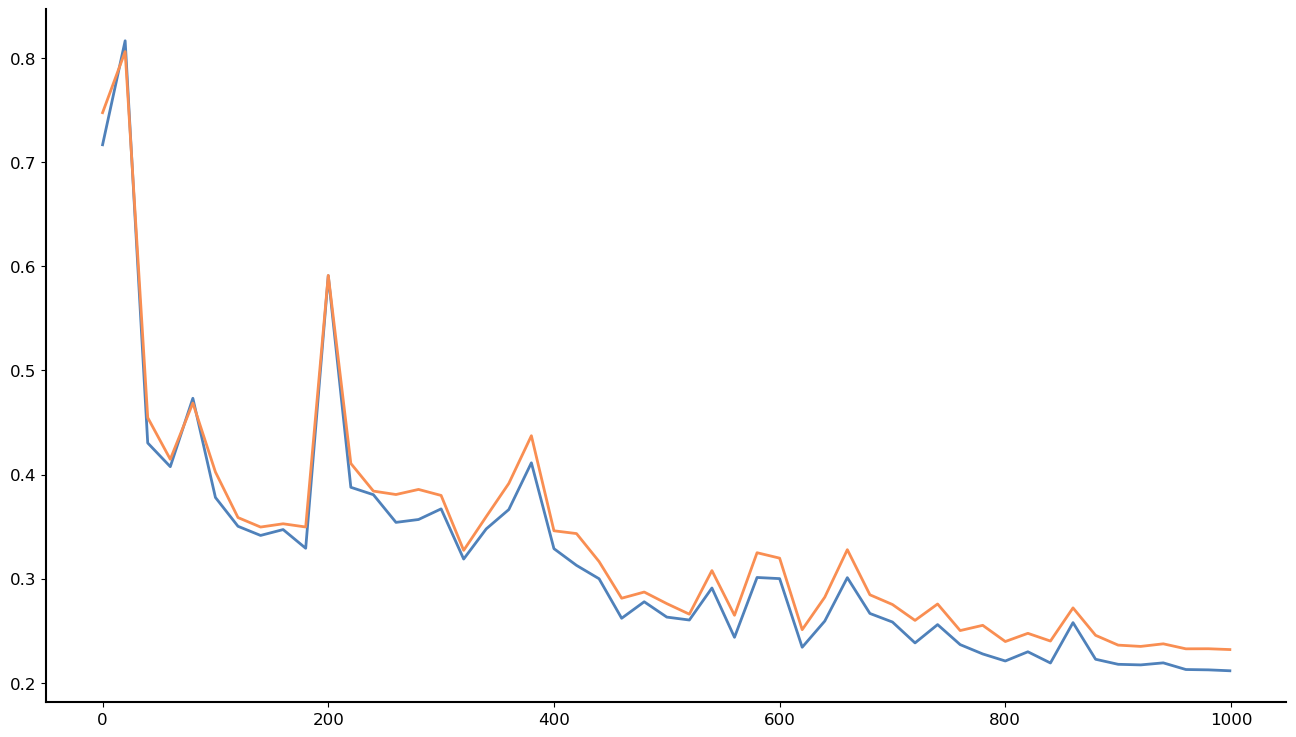

In [53]:
fig = plt.figure(figsize=(FIG_W, FIG_H))

epoch = [row['epoch'] for row in report]
training_loss = [row['training_loss'] for row in report]
eval_loss = [row['eval_loss'] for row in report]

sns.lineplot(x=epoch, y=training_loss,
             color=colors['blue'], linewidth=2)
sns.lineplot(x=epoch, y=eval_loss,
             color=colors['orange'], linewidth=2)

ax = fig.gca()

sns.despine()
set_ax(ax)

In the following figure, we visualize the trend of training and evaluation accuracy over the course of training. 

As before, the x-axis represents the training epochs. The blue line shows the accuracy for the training data set and orange line for the evaluation set. The figure shows how the classification accuracy of the model improves as the training progresses, plateauing around 90% correct classifications towards the end of training.

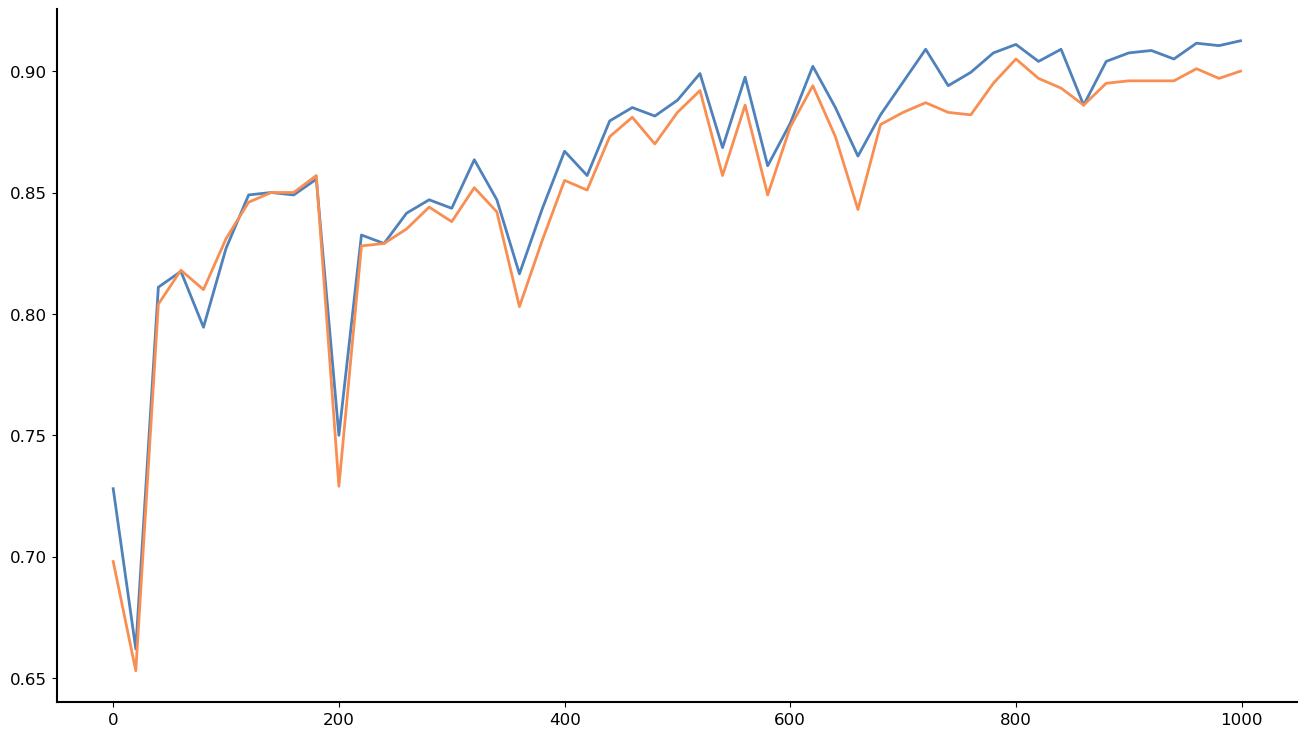

In [54]:
fig = plt.figure(figsize=(FIG_W, FIG_H))

epoch = [row['epoch'] for row in report]
training_accuracy = [row['training_accuracy'] for row in report]
eval_accuracy = [row['eval_accuracy'] for row in report]

sns.lineplot(x=epoch, y=training_accuracy,
             color=colors['blue'], linewidth=2)
sns.lineplot(x=epoch, y=eval_accuracy,
             color=colors['orange'], linewidth=2)

ax = fig.gca()

sns.despine()
set_ax(ax)

## Visualizing classification probabilities

Our neural network model outputs logit values for each class. Applying a softmax function, we can convert the outputs into probabilities. Higher logits or probabilities indicate a higher confidence or likelihood of a particular class being the correct prediction. The relative differences in magnitude between the logits or probabilities for different classes reflect the model's confidence in assigning each class label.

The class with the largest logit value or the highest predicted probability is considered the predicted class. The point where the probabilities of two adjacent classes are equal forms the decision boundary. At this boundary, the model's estimated likelihood of belonging to either class is the same. By establishing the decision boundaries, we also determine the regions in the input space where the model assigns one class over another.

We provide an example visualization of the classification probabilties of our neural network model and how the class boundaries are formed. For this, we take a vertical cross-section of the two-dimensional input space, and illustrate predicted class probabilities along that line.

In the following figure, the location of the selected cross-section at $x_1=8$ is indicated by a vertical blue line, intersecting the class boundary centerlines shown in the figure. 

In [55]:
x1_crossing = 8

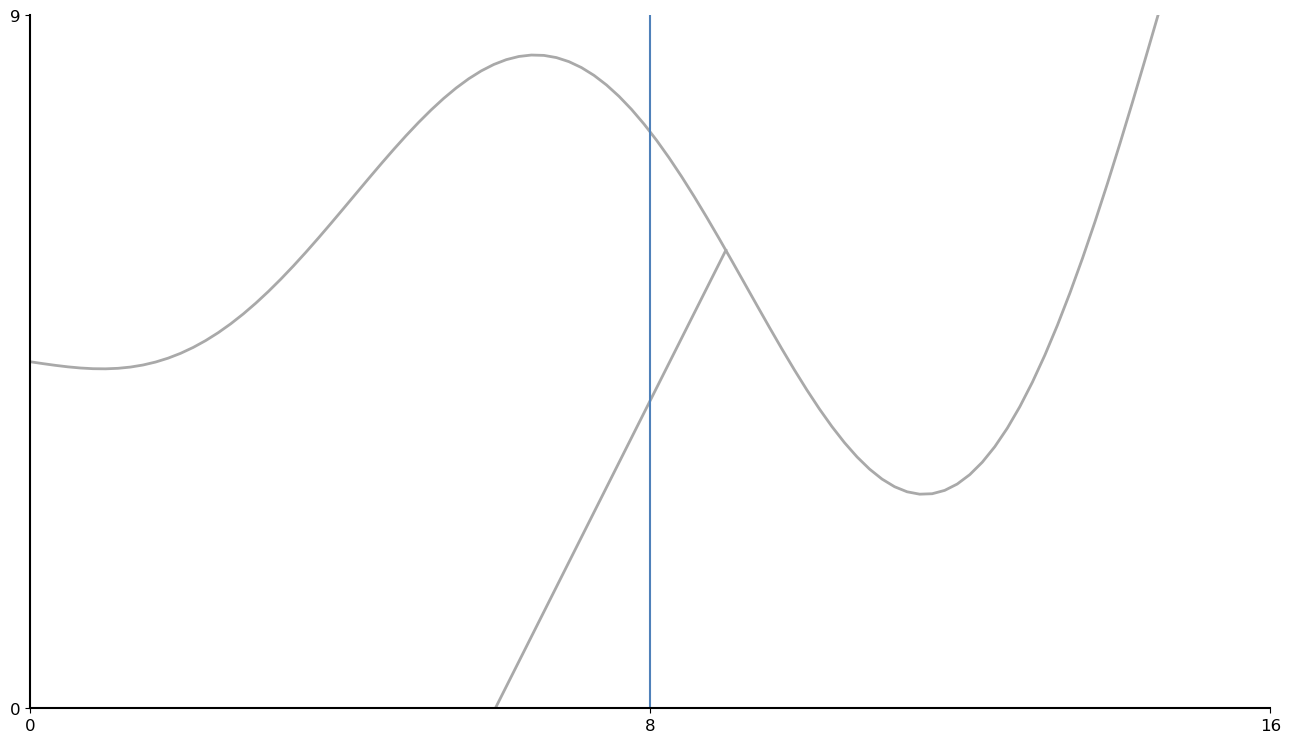

In [56]:
fig = plt.figure(figsize=(FIG_W, FIG_H))

plot_class_boundaries()

plt.plot([x1_crossing, x1_crossing],
         [X2_MIN, X2_MAX], color=colors['blue'])

ax = fig.gca()

sns.despine()
set_ax(ax)
set_axlim(ax)

_ = ax.set_xticks([X1_MIN, x1_crossing, X1_MAX])

As preparation, we first create a test input data, where `x1 = 8`, and `x2` ranges from `X2_MIN` to `X2_MAX`. The neural network model is used to obtain the logits, `test_logits`, for these test inputs. 

The model outputs are then passed through the softmax function using `torch.softmax` to obtain the corresponding classification probabilities. The outputs of the softmax function indicate the likelihood of each input sample belonging to different classes.
 
For continued analysis, we store the classification probabilities in a [long format](https://pandas.pydata.org/docs/getting_started/intro_tutorials/07_reshape_table_layout.html#wide-to-long-format) Pandas `Dataframe`, containing the predicted class probabilities for each of the three classes at each $x_2$ value on our cross-section.

In [57]:
steps = 300
x2_section = np.linspace(X2_MIN, X2_MAX, steps)

test_inputs = torch.column_stack((x1_crossing * torch.ones(steps, dtype=torch.float32),
                                  torch.tensor(x2_section, dtype=torch.float32))).to(device)
test_logits = model(test_inputs)

with torch.no_grad():
    test_probs = torch.softmax(test_logits, dim=1)

tp_pd = pd.DataFrame(test_probs.to('cpu').numpy())

tp_pd['x2'] = x2_section
tp_pd_long = tp_pd.melt('x2', var_name='class', value_name='prob')

We take a peek at the resulting Dataframe.

In [58]:
display(tp_pd_long)

,x2,class,prob
0,0.000000,0,0.984078
1,0.030100,0,0.984092
2,0.060201,0,0.984107
3,0.090301,0,0.984123
4,0.120401,0,0.984140
...,...,...,...
895,8.879599,2,0.929415
896,8.909699,2,0.934490
897,8.939799,2,0.939298
898,8.969900,2,0.943844


We record the locations of the class boundary center points between classes 0 and 1, and classes 1 and 2 at the cross-section.

In [59]:
x01_real = func2(torch.FloatTensor([x1_crossing])).item()
x12_real = func1(torch.FloatTensor([x1_crossing])).item()

print(f"x01_real: {x01_real:.2f}, x02_real: {x12_real:.2f}")

x01_real: 4.00, x02_real: 7.48


By finding the roots or points where the difference between the probabilities of two classes changes sign, we can identify the position along the cross-section where the estimated class boundary lies. 

So below, we find the `x2` values where the predicted probabilities are equal using our `find_roots` function on the difference between the class probabilities.


In [60]:
x01 = torch.FloatTensor(tp_pd_long.loc[tp_pd_long['class'] == 0, 'prob'].to_numpy()
                        - tp_pd_long.loc[tp_pd_long['class'] == 1, 'prob'].to_numpy())

x12 = torch.FloatTensor(tp_pd_long.loc[tp_pd_long['class'] == 1, 'prob'].to_numpy()
                        - tp_pd_long.loc[tp_pd_long['class'] == 2, 'prob'].to_numpy())

# for multiple values, take the last one

x01_pred = find_roots(torch.FloatTensor(x2_section), x01)[-1].item()
x12_pred = find_roots(torch.FloatTensor(x2_section), x12)[-1].item()

print(f"x01_pred: {x01_pred:.2f}, x12_pred: {x12_pred:.2f}")

x01_pred: 3.84, x12_pred: 7.41


The following plot shows the predicted class probabilities at the cross-section, i.e. along the blue vertical line in the previous plot. 

The x-axis represents the position on the cross-section, while the y-axis represents the probability value. The used line colors represent different classes as in previous visualizations.

Each line on the plot represents the estimated likelihood of an input sample at that point of the cross-section belonging to a specific class. We note the locations of estimated class boundaries by setting x-axis tick marks at the root values we just calculated.

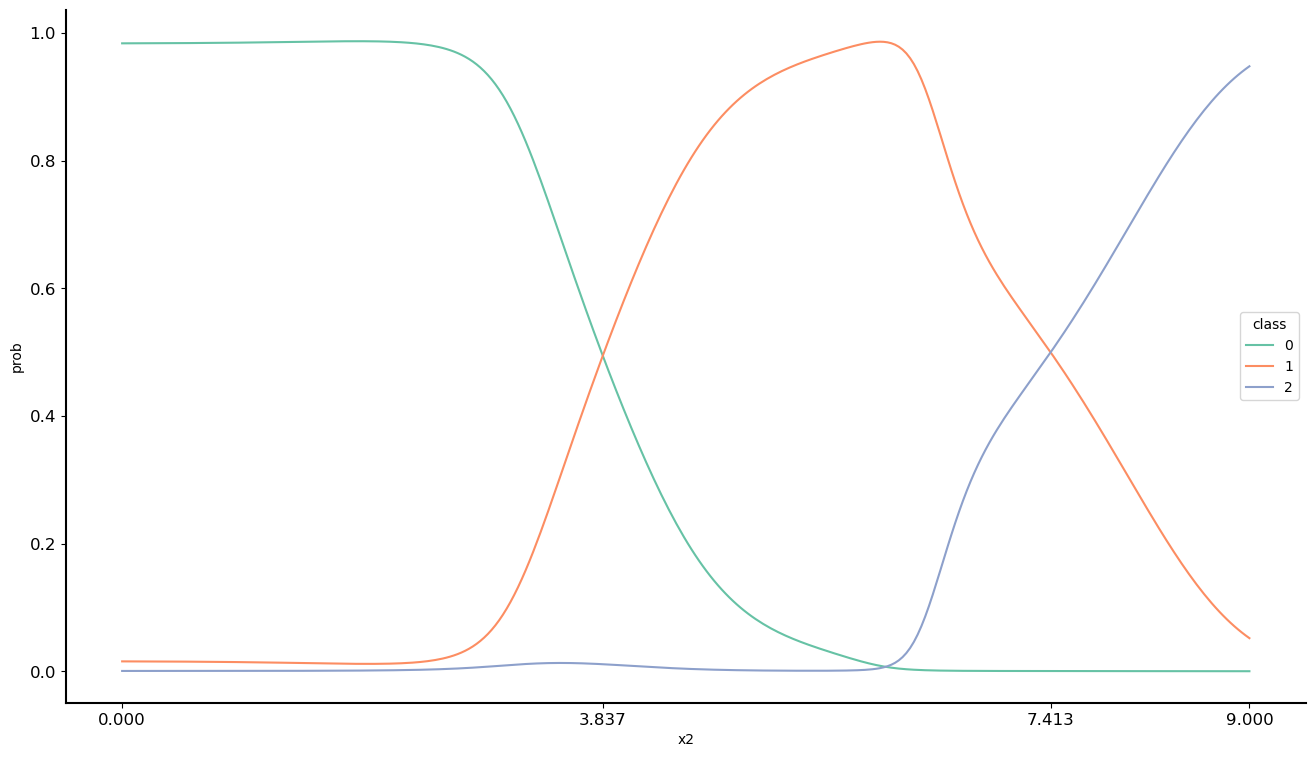

In [61]:
fig = plt.figure(figsize=(FIG_W, FIG_H))

sns.lineplot(data=tp_pd_long,
             x='x2',
             y='prob',
             hue='class',
             palette=class_colors,
             legend=True)

ax = fig.gca()

ax.set_xticks([X2_MIN, x01_pred, x12_pred, X2_MAX])

sns.despine()
set_ax(ax)

### Visualize Classification Predictions

Now that we have explored how model outputs from class boundaries we are ready to visualize the model estmated classification boundaries and compare the predicted values to ground-truth values defined by the class boundary center points.

We wish to utilize matplotlib's `pyplot.contour` ([link](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html)) to visualize the class boundaries, so we define some helper functions before we proceed.

First, the `create_class_predictions` function will calculate the class predictions for sampled points in our two-dimensional input space, defined by the predefined minimum and maximum values. It creates a [Cartesian product](https://en.wikipedia.org/wiki/Cartesian_product) of `x1` and `x2` values to generate all possible combinations of the input feature values.

The input feature values are passed through the neural network model to obtain the output predictions. `torch.max` function is then used to find the index of the class with the highest logit (and thus, highest probability) for each input sample.

Second, the `get_predictions_as_grid` function converts the array of class predictions into a grid format. The function creates a grid of x, y, and z values representing the coordinates and predicted classes for each point on the grid. We employ `pivot_table` from the Pandas library ([link](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html)) for this task.


In [62]:
def create_class_predictions(model):

    steps = 600

    x1_values = torch.linspace(X1_MIN, X1_MAX, steps=steps)
    x2_values = torch.linspace(X2_MIN, X2_MAX, steps=steps)

    input = torch.cartesian_prod(x1_values,
                                 x2_values).to(device)
    output = model(input)

    _, ind = torch.max(output, dim=1)
    return torch.hstack((input, ind.unsqueeze(-1))).to('cpu').detach().numpy()

In [63]:
def get_predictions_as_grid(pred_as_array):

    df_pred = pd.DataFrame(pred_as_array, columns=['x', 'y', 'z'])

    z = df_pred.pivot_table(index='x', columns='y', values='z').T.values
    x = np.sort(df_pred.x.unique())
    y = np.sort(df_pred.y.unique())

    return x, y, z

Now, applying the two helper functions, we visualize the model estimated class decision boundaries for our simple classification problem.

The Matplotlib `plt.contour` function is used to draw contour lines at specific levels to represent the class boundaries. In this case, the contour levels are set to `[0.9, 1.1]`, which indicates the region where the class probabilities transition from one class to another.

We use gray to indicate the ground truth reference values and blue to indicate the model estimated class boundary.

We also map the real and estimated decision points along the vertical cross-section (values `x01_real` and `x01_pred`, `x12_real` and `x12_pred`). We indicate these points as blue and gray crosses at the corresponding boundaries.

In [64]:
class_preds = create_class_predictions(model)

In [65]:
grid_x, grid_y, grid_z = get_predictions_as_grid(class_preds)

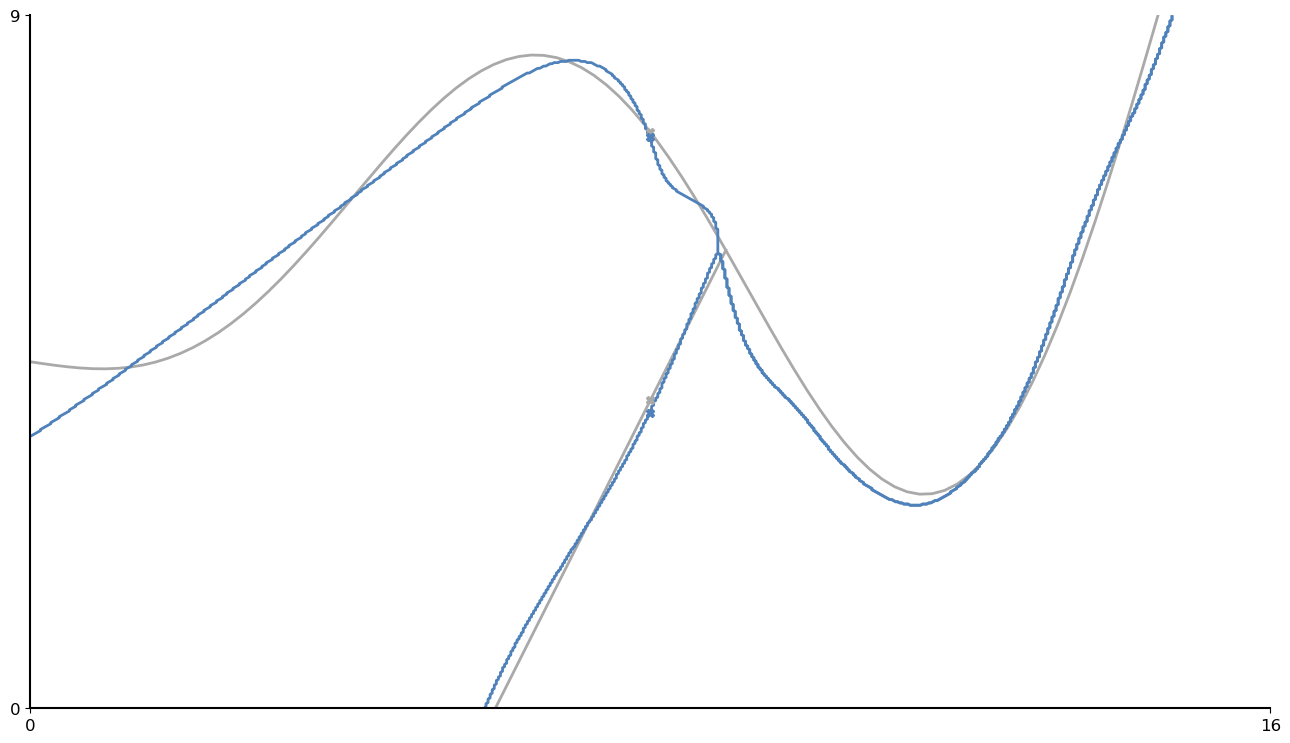

In [66]:
fig = plt.figure(figsize=(FIG_W, FIG_H))

plot_class_boundaries()

color_as_str = rgb2hex(colors['blue'])

plt.contour(grid_x, grid_y, grid_z,
            levels=[0.9, 1.1],
            colors=color_as_str, linewidths=2)

plt.plot(x1_crossing, x01_real, 'X', color='darkgray')
plt.plot(x1_crossing, x01_pred, 'X', color=colors['blue'])
plt.plot(x1_crossing, x12_real, 'X', color='darkgray')
plt.plot(x1_crossing, x12_pred, 'X', color=colors['blue'])

ax = fig.gca()

sns.despine()
set_ax(ax)
set_axlim(ax)

### Visualize Evolution of Class Decision Boundaries during Training

As the final illustration of the learning process, we explore how the class boundaries evolve during training. We do this by plotting contour lines at different epochs, reflecting the changing predictions of the neural network as it learns from the data.

We iterate over the report list, where we stored the model's state at different epochs during training. We  load the model state dictionary and set the model's parameters and weights to the values saved at that particular epoch.

We then utilize a same logic as for the final model state above: we generate class predictions and convert them into a grid format, again using `plt.contour` to draw contour lines on the plot, representing the class boundaries at that epoch.

We assign a color based on the relative progress of the epoch according to our predefined colormap, colors ranging from dark blue in early epochs to light green towards end of training.

Additionally, we show the target ground-truth value in black and emphasize the final model output at the end of training in yellow.

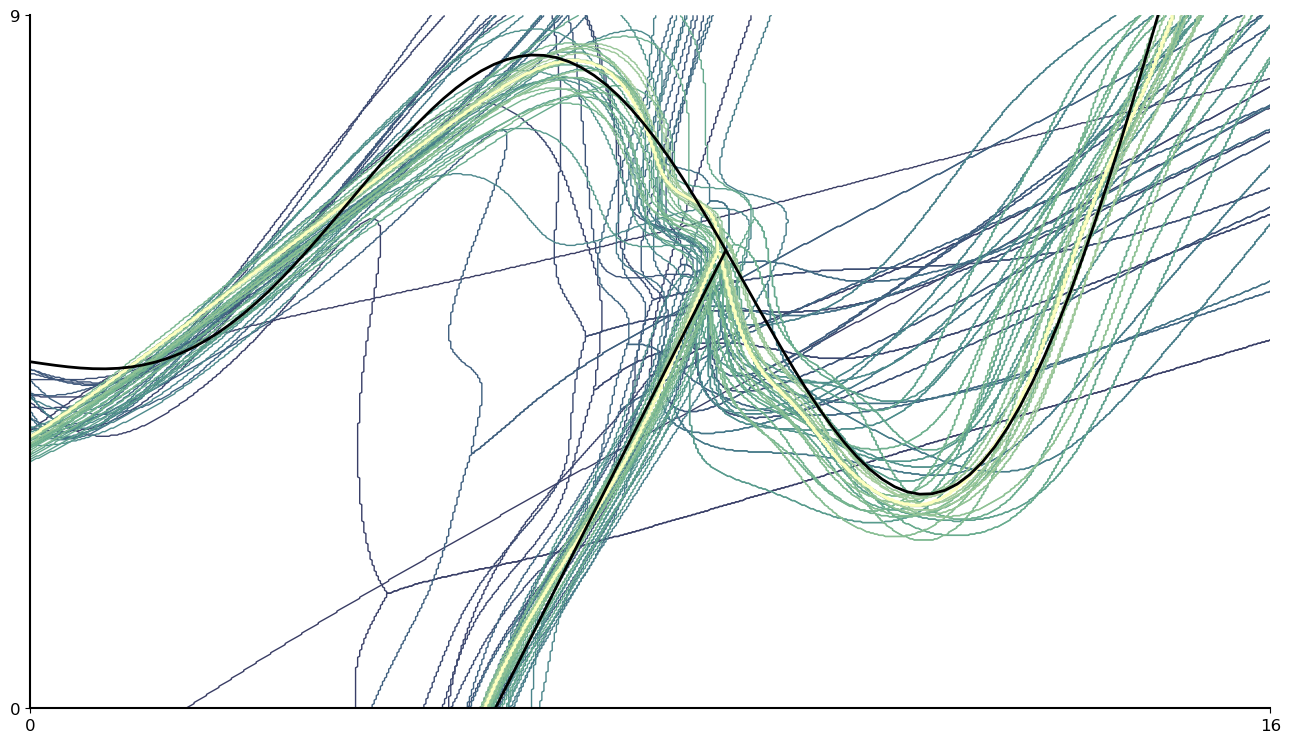

In [67]:
fig = plt.figure(figsize=(FIG_W, FIG_H))

for row in report:
    model.load_state_dict(row['state_dict'])

    class_preds = create_class_predictions(model)
    grid_x, grid_y, grid_z = get_predictions_as_grid(class_preds)

    color = palette(row['epoch'] / report[-1]['epoch'])
    color_as_str = rgb2hex(color)

    plt.contour(grid_x, grid_y, grid_z, levels=[
                0.9, 1.1], colors=color_as_str, linewidths=1)

# emphasize final line

color_as_str = rgb2hex(colors['yellow'])
plt.contour(grid_x, grid_y, grid_z, levels=[
            0.99, 1.01], colors=color_as_str, linewidths=2)

# target

plot_class_boundaries(color='black')

ax = fig.gca()

sns.despine()
set_ax(ax)
set_axlim(ax)

As the plot becomes somewhat cluttered, we hope to present the plot below in a clearer manner: We divide the plot into subplots to showcase different stages of learning across the training epochs.

In the [previous plot](#visualizinglosses) showing the evolution of training and evaluation loss during the training process, two abrupt jumps in loss values were observed around 200 epochs and 380 epochs of training. We note the loss values around these epochs below.

Find the corresponding changes in the classification boundaries in fourth subplot on first row (for epochs 180, 200 and 220) and second subplot on second row (epochs 360, 380 and 400).

In [68]:
epochs = [180, 200, 220]

_ = [print(f"Epoch: {row['epoch']}, training loss: {row['training_loss']:.4f}")
     for row in report if row['epoch'] in epochs]

Epoch: 180, training loss: 0.3292
Epoch: 200, training loss: 0.5909
Epoch: 220, training loss: 0.3878


In [69]:
epochs = [360, 380, 400]

_ = [print(f"Epoch: {row['epoch']}, training loss: {row['training_loss']:.4f}")
     for row in report if row['epoch'] in epochs]

Epoch: 360, training loss: 0.3664
Epoch: 380, training loss: 0.4113
Epoch: 400, training loss: 0.3289


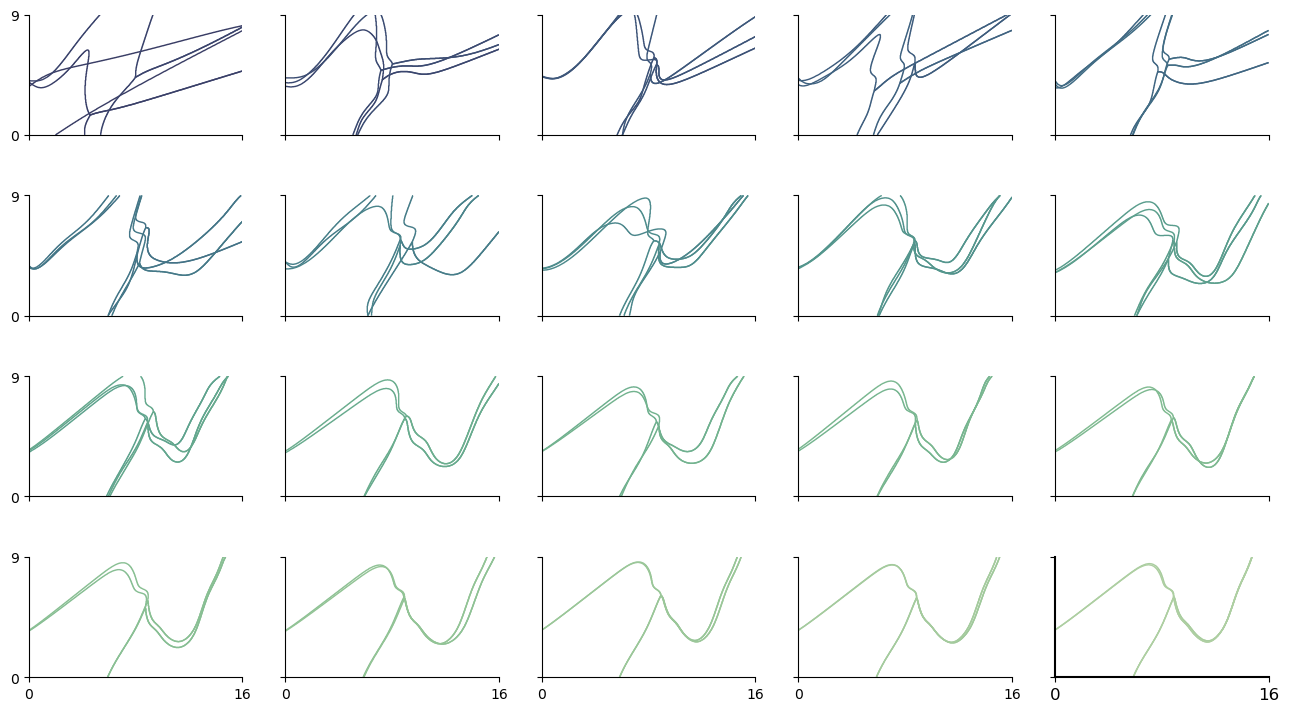

In [70]:
rows = 4
columns = 5

sub_arrays = np.array_split(range(len(report)), rows * columns)

fig, axes = plt.subplots(rows, columns, figsize=(FIG_W, FIG_H),
                         sharex=True, sharey=True,
                         subplot_kw={'box_aspect': FIG_H/FIG_W})

for i, sb in enumerate(sub_arrays):

    ax = axes.flat[i]
    plt.sca(ax)

    for row_indx in sb:
        row = report[row_indx]

        model.load_state_dict(row['state_dict'])

        class_preds = create_class_predictions(model)
        grid_x, grid_y, grid_z = get_predictions_as_grid(class_preds)

        color = palette(row['epoch'] / report[-1]['epoch'])
        color_as_str = rgb2hex(color)

        plt.contour(grid_x, grid_y, grid_z, levels=[
                    0.9, 1.1], colors=color_as_str, linewidths=1)

sns.despine()
set_ax(ax)
set_axlim(ax)

## Summary

In this notebook, we explored the implementation of a simple classification neural network using PyTorch. We focused on a simple 2D classification problem to facilitate visualization and to better understand the learning process.

Using PyTorch, we defined the architecture of our neural network by leveraging the `nn.Module` class. We utilized the `nn.Sequential` module to conveniently compose the sequential layers of our network. We trained our model using standard techniques including stochastic gradient descent (SGD) optimization and cross-entropy loss.

Despite minimal effort in selecting the neural network architecture and fine-tuning the learning parameters, our model achieved adequate performance.

Importantly, the code and techniques presented in this notebook are not limited to the simple classification problem explored here. They can be applied to real-world classification problems by adapting the code to specific datasets and adjusting the network architecture accordingly.

Further exploration can be done to investigate the minimal size of the hidden layer required to achieve satisfactory classification performance, and to examine the effects of using a larger and more powerful hidden layer, which may lead to overfitting and a potential degradation in the model's ability to generalize to unseen data. Also, further work could involve experimenting with various learning parameter settings to optimize the model's performance. 

This notebook serves as a starting point for further exploration of classification problems and neural network architectures. It provides a solid foundation to tackle more complex classification tasks and delve deeper into the realm of deep learning.
